## FNN for Skyrmion trajectories prediction

**Imports**

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import trackpy as tp
from tqdm import tqdm  # for progress bar

# import functions
from my_functions import *

**Read the data**

In [2]:
directory = 'Rec_EDGE_300K_1L_50MA.out'
data = pd.read_csv(directory + '/filled_trajectories.csv')
data = data.drop(data.columns[0], axis=1)
no_skyrmions = data[data['frame'] == 0].shape[0]

data

,y,x,frame,particle
0,24.420047,61.809992,0.0,0.0
1,31.518261,109.009463,0.0,1.0
2,51.658864,41.007417,0.0,2.0
3,60.994689,82.173861,0.0,3.0
4,61.572998,129.252586,0.0,4.0
...,...,...,...,...
11995,26.838018,9158.734705,799.0,10.0
11996,92.153535,8909.539660,799.0,11.0
11997,160.675052,8812.401110,799.0,12.0
11998,156.663224,8600.194927,799.0,13.0


**Put data in list**

In [3]:
no_skyrmions = int(max(data[data['frame'] == 0]['particle']) + 1)

frames = None

# iterate through the frames
for f in tqdm(data['frame'].unique()):
    coordinates = None
    for p in data[data['frame'] == f]['particle']:
        particle = data[(data['frame'] == f) & (data['particle'] == p)]
        coordinates = np.append(coordinates, [particle['x'].values[0], particle['y'].values[0]]) if coordinates is not None else [particle['x'].values[0], particle['y'].values[0]]
    
    frames = np.append(frames, coordinates) if frames is not None else [coordinates]
                                                                        
frames = frames.reshape(-1, 2 * no_skyrmions)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:06<00:00, 123.98it/s]


## One image input

**Make data samples**

In [4]:
# Samples are (frame, next_frame)

X = frames[:-1]
y = frames[1:]

**Split data for training and testing**

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [6]:
print("X_train shape: " + str(X_train.shape))
print("y_train shape: " + str(y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("y_test shape: " + str(y_test.shape))

X_train shape: (639, 30)
y_train shape: (639, 30)
X_test shape: (160, 30)
y_test shape: (160, 30)


**Hyperparameters**

In [7]:
activation = 'relu'

optimizer = 'NAdam'
loss = 'mae'
metrics = ['accuracy']
training_epochs = 1000
batch_size = 64

n_input = 2 * no_skyrmions
n_hidden_1 = 64
n_hidden_2 = 64
n_hidden_3 = 64
n_output = 2 * no_skyrmions

**Build Neural Network**

In [8]:
#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers

# Neural network
model = Sequential()
model.add(Dense(n_hidden_1, input_dim=n_input, activation=activation, kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dense(n_hidden_2, activation=activation, kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dense(n_hidden_3, activation=activation, kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dense(n_output))

Using TensorFlow backend.


In [9]:
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [10]:
history = model.fit(X_train, y_train, validation_data = (X_test,y_test), epochs=training_epochs)

Train on 639 samples, validate on 160 samples
Epoch 1/1000
639/639 [==============================] - 0s 378us/step - loss: 1580.2537 - accuracy: 0.0642 - val_loss: 676.4967 - val_accuracy: 0.3750
Epoch 2/1000
639/639 [==============================] - 0s 61us/step - loss: 313.2213 - accuracy: 0.1643 - val_loss: 228.5528 - val_accuracy: 0.0812
Epoch 3/1000
639/639 [==============================] - 0s 56us/step - loss: 189.2074 - accuracy: 0.1236 - val_loss: 182.4017 - val_accuracy: 0.1937
Epoch 4/1000
639/639 [==============================] - 0s 51us/step - loss: 165.6381 - accuracy: 0.2222 - val_loss: 73.2899 - val_accuracy: 0.3938
Epoch 5/1000
639/639 [==============================] - 0s 53us/step - loss: 136.3814 - accuracy: 0.1315 - val_loss: 131.0051 - val_accuracy: 0.0500
Epoch 6/1000
639/639 [==============================] - 0s 39us/step - loss: 149.8216 - accuracy: 0.2911 - val_loss: 167.9790 - val_accuracy: 0.1437
Epoch 7/1000
639/639 [==============================] - 0s 

In [11]:
prediction = model.predict(X_test)
print(y_test[0])
print(prediction[0])

[3959.79927654   88.38690687 3833.36343175   73.86084999 3720.26202803
   80.89942707 3875.73527218   89.76332243 3984.65855778   61.87102125
 3719.09628146  182.6610984  3820.20357804  120.41394201 3784.76640989
  129.26342628 4008.75510365   97.71687554 3794.63708076  176.50269565
 4028.530833     41.54125543 3908.45807054   92.69808456 3837.47288001
  158.77981372 3639.46159761  148.1763349  3754.47286213  171.42434555]
[3930.4724     94.14286  3813.228      71.28311  3704.6692     81.81841
 3854.9978     97.633316 3959.8105     52.63658  3693.191     177.30429
 3792.008     127.32965  3760.1562    139.93283  3995.86       85.98746
 3771.652     176.88643  4002.2498     49.231865 3880.1807     88.90663
 3808.5774    151.40303  3619.0918    162.06358  3713.0576    170.9978  ]


**Predict of test data**

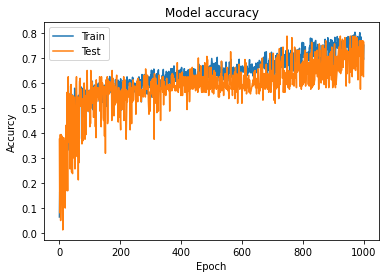

In [12]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accurcy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

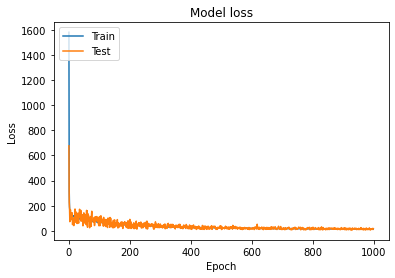

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

## Two imges input

In [14]:
# Samples are ((frame, frame), next_frame)

X = None

for i in range(len(frames) - 2):
    X = np.append(X, np.append(frames[i], frames[i+1])) if X is not None else np.append(frames[i], frames[i+1])
X = X.reshape(-1, 4 * no_skyrmions)
y = frames[2:]

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [16]:
print("X_train shape: " + str(X_train.shape))
print("y_train shape: " + str(y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("y_test shape: " + str(y_test.shape))

X_train shape: (638, 60)
y_train shape: (638, 30)
X_test shape: (160, 60)
y_test shape: (160, 30)


In [17]:
activation = 'relu'

optimizer = 'NAdam'
loss = 'mae'
metrics = ['accuracy']
training_epochs = 1000
batch_size = 64

n_input = 4 * no_skyrmions
n_hidden_1 = 64
n_hidden_2 = 64
n_hidden_3 = 64
n_output = 2 * no_skyrmions

In [18]:
#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers

# Neural network
model = Sequential()
model.add(Dense(n_hidden_1, input_dim=n_input, activation=activation, kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dense(n_hidden_2, activation=activation, kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dense(n_hidden_3, activation=activation, kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dense(n_output))

In [19]:
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [20]:
history = model.fit(X_train, y_train, validation_data = (X_test,y_test), epochs=training_epochs)

Train on 638 samples, validate on 160 samples
Epoch 1/1000
638/638 [==============================] - 0s 278us/step - loss: 1482.4425 - accuracy: 0.0737 - val_loss: 584.5781 - val_accuracy: 0.3812
Epoch 2/1000
638/638 [==============================] - 0s 53us/step - loss: 387.8674 - accuracy: 0.1536 - val_loss: 189.8469 - val_accuracy: 0.2438
Epoch 3/1000
638/638 [==============================] - 0s 48us/step - loss: 201.8183 - accuracy: 0.2476 - val_loss: 204.3425 - val_accuracy: 0.2625
Epoch 4/1000
638/638 [==============================] - 0s 47us/step - loss: 174.9707 - accuracy: 0.1677 - val_loss: 132.2345 - val_accuracy: 0.0312
Epoch 5/1000
638/638 [==============================] - 0s 45us/step - loss: 144.2128 - accuracy: 0.1865 - val_loss: 147.6192 - val_accuracy: 0.2625
Epoch 6/1000
638/638 [==============================] - 0s 36us/step - loss: 165.0457 - accuracy: 0.1881 - val_loss: 178.0202 - val_accuracy: 0.0812
Epoch 7/1000
638/638 [==============================] - 0s

In [21]:
prediction = model.predict(X_test)
print(y_test[0])
print(prediction[0])

[3959.79927654   88.38690687 3833.36343175   73.86084999 3720.26202803
   80.89942707 3875.73527218   89.76332243 3984.65855778   61.87102125
 3719.09628146  182.6610984  3820.20357804  120.41394201 3784.76640989
  129.26342628 4008.75510365   97.71687554 3794.63708076  176.50269565
 4028.530833     41.54125543 3908.45807054   92.69808456 3837.47288001
  158.77981372 3639.46159761  148.1763349  3754.47286213  171.42434555]
[3960.7578    100.152374 3852.027      69.33155  3737.2583     71.16962
 3887.0532     79.31982  3964.9758     47.215065 3699.0647    160.28706
 3814.3845    122.85479  3789.8206    125.994095 4012.2092     96.01089
 3805.9556    170.78809  4012.113      49.387844 3889.7249     81.48714
 3843.043     148.57962  3647.4678    150.5106   3748.323     160.23267 ]


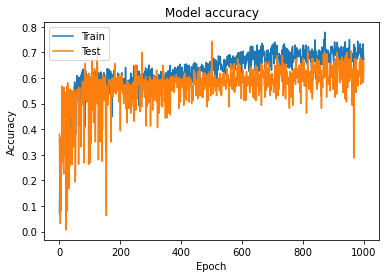

In [22]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

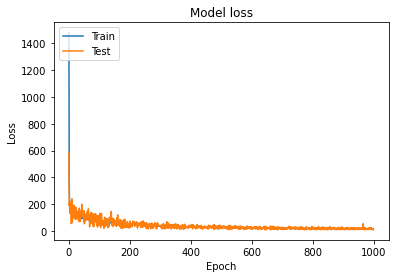

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

## Predict n images (frame, next n frames)

In [24]:
n = 5

# data in format (frame, next n frames)
dfn = pd.DataFrame(columns=['X', 'y'])

for i in range(n, len(frames)):
    target = []
    for j in range(n-1, -1, -1):
        target = target + frames[i-j].tolist()
    dfn = dfn.append({'X': frames[i-2], 'y': target}, ignore_index=True)

dfn

,X,y
0,"[92.43681939593179, 22.50037668652832, 141.306...","[70.80009877085162, 22.786106233538195, 115.03..."
1,"[104.5978211529732, 22.04513325984048, 153.672...","[78.53846153846153, 23.79722075869336, 130.692..."
2,"[114.654700661428, 17.817739838317607, 167.487...","[92.43681939593179, 22.50037668652832, 141.306..."
3,"[130.2578821609651, 15.584474619733086, 177.42...","[104.5978211529732, 22.04513325984048, 153.672..."
4,"[137.88253604193972, 15.713794233289649, 183.3...","[114.654700661428, 17.817739838317607, 167.487..."
...,...,...
790,"[8963.531319216798, 166.59466643040668, 8880.4...","[8940.46656641604, 155.12932330827067, 8861.91..."
791,"[8971.234802590348, 161.42225471763803, 8889.3...","[8954.623459439574, 159.4531853577779, 8867.34..."
792,"[8981.526291116494, 162.7594343308071, 8905.46...","[8963.531319216798, 166.59466643040668, 8880.4..."
793,"[8990.157367074604, 162.0370600843532, 8920.93...","[8971.234802590348, 161.42225471763803, 8889.3..."


In [25]:
from sklearn.model_selection import train_test_split

X = dfn['X'].tolist()
y = dfn['y'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [26]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [27]:
print("X_train shape: " + str(X_train.shape))
print("y_train shape: " + str(y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("y_test shape: " + str(y_test.shape))

X_train shape: (636, 30)
y_train shape: (636, 150)
X_test shape: (159, 30)
y_test shape: (159, 150)


In [28]:
activation = 'relu'

optimizer = 'NAdam'
loss = 'mae'
metrics = ['accuracy']
training_epochs = 1000
batch_size = 64

n_input = 2 * no_skyrmions
n_hidden_1 = 64
n_hidden_2 = 64
n_hidden_3 = 64
n_output = 2 * no_skyrmions * n

In [29]:
#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers

# Neural network
model = Sequential()
model.add(Dense(n_hidden_1, input_dim=n_input, activation=activation, kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dense(n_hidden_2, activation=activation, kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dense(n_hidden_3, activation=activation, kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dense(n_output))

In [30]:
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [31]:
history = model.fit(X_train, y_train, validation_data = (X_test,y_test), epochs=training_epochs)

Train on 636 samples, validate on 159 samples
Epoch 1/1000
636/636 [==============================] - 0s 282us/step - loss: 1502.5858 - accuracy: 0.0016 - val_loss: 423.4865 - val_accuracy: 0.0000e+00
Epoch 2/1000
636/636 [==============================] - 0s 53us/step - loss: 272.5306 - accuracy: 0.0252 - val_loss: 157.3624 - val_accuracy: 0.0000e+00
Epoch 3/1000
636/636 [==============================] - 0s 52us/step - loss: 175.8958 - accuracy: 0.1682 - val_loss: 228.6469 - val_accuracy: 0.3774
Epoch 4/1000
636/636 [==============================] - 0s 49us/step - loss: 167.3197 - accuracy: 0.0314 - val_loss: 173.6216 - val_accuracy: 0.0692
Epoch 5/1000
636/636 [==============================] - 0s 52us/step - loss: 158.5492 - accuracy: 0.0063 - val_loss: 126.2378 - val_accuracy: 0.0000e+00
Epoch 6/1000
636/636 [==============================] - 0s 44us/step - loss: 142.2317 - accuracy: 0.0000e+00 - val_loss: 149.4156 - val_accuracy: 0.0000e+00
Epoch 7/1000
636/636 [================

In [32]:
prediction = model.predict(X_test)
print(y_test[0])
print(prediction[0])

[3938.39828594   91.7991629  3823.63320293   70.77795305 3711.30403945
   78.46771143 3864.70386455   89.46871853 3968.49103253   61.90130712
 3705.49172961  184.79185391 3814.45072736  116.1817613  3775.53604743
  128.80332016 3993.09488747   91.0887052  3785.55524457  177.51812608
 4023.09569408   39.62329453 3894.38311279   94.74970244 3834.750479
  158.6257185  3630.57702847  152.64446643 3736.80278395  169.00163762
 3959.79927654   88.38690687 3833.36343175   73.86084999 3720.26202803
   80.89942707 3875.73527218   89.76332243 3984.65855778   61.87102125
 3719.09628146  182.6610984  3820.20357804  120.41394201 3784.76640989
  129.26342628 4008.75510365   97.71687554 3794.63708076  176.50269565
 4028.530833     41.54125543 3908.45807054   92.69808456 3837.47288001
  158.77981372 3639.46159761  148.1763349  3754.47286213  171.42434555
 3969.41995256   91.99066113 3848.50261704   76.59341378 3730.22105916
   78.53563804 3886.60946468   86.18470208 3984.65855778   61.87102125
 3722.52

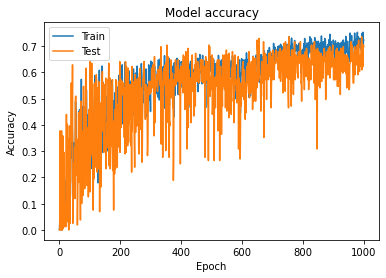

In [33]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

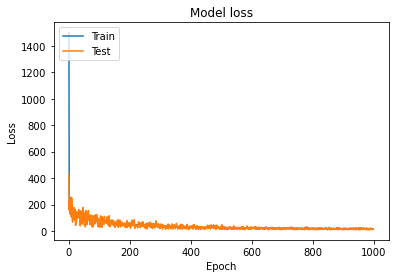

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

## How are the results affected if I try to predict on using my prediction as input data? For how many rounds can this be accurate enough?

In [35]:
n = 50

# data in columns format (frame, next frame, next next frame, ...)
df_n_rounds = pd.DataFrame(columns=['X', 'y_1'])

for i in range(1, n):
    df_n_rounds['y_' + str(i+1)] = ''

for i in range(n+1):
    col = []
    for j in range(i, len(frames)-n+i):
        col.append(frames[j])
    if i == 0:
        df_n_rounds['X'] = col
    else:
        df_n_rounds['y_' + str(i)] = col

df_n_rounds

,X,y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,...,y_41,y_42,y_43,y_44,y_45,y_46,y_47,y_48,y_49,y_50
0,"[61.80999150562753, 24.420046719048628, 109.00...","[70.80009877085162, 22.786106233538195, 115.03...","[78.53846153846153, 23.79722075869336, 130.692...","[92.43681939593179, 22.50037668652832, 141.306...","[104.5978211529732, 22.04513325984048, 153.672...","[114.654700661428, 17.817739838317607, 167.487...","[130.2578821609651, 15.584474619733086, 177.42...","[137.88253604193972, 15.713794233289649, 183.3...","[151.1877135081929, 20.428405998494586, 191.79...","[165.68593072270755, 20.306249618180708, 203.6...",...,"[548.3095747526077, 55.4499866274405, 542.7064...","[559.3591679425583, 54.50747056649596, 551.733...","[571.6816533108394, 56.70940531421341, 561.582...","[579.4599029964786, 54.63856222177928, 574.765...","[595.5333143912487, 52.484301747407294, 584.49...","[608.6178598298512, 54.07367324497946, 596.594...","[616.5485332302082, 54.14087619468538, 610.544...","[630.1560680698611, 48.47305567995223, 624.534...","[645.4160783268949, 54.60836552550953, 632.508...","[655.4035507361932, 59.76984000425239, 648.778..."
1,"[70.80009877085162, 22.786106233538195, 115.03...","[78.53846153846153, 23.79722075869336, 130.692...","[92.43681939593179, 22.50037668652832, 141.306...","[104.5978211529732, 22.04513325984048, 153.672...","[114.654700661428, 17.817739838317607, 167.487...","[130.2578821609651, 15.584474619733086, 177.42...","[137.88253604193972, 15.713794233289649, 183.3...","[151.1877135081929, 20.428405998494586, 191.79...","[165.68593072270755, 20.306249618180708, 203.6...","[175.51762512381282, 22.85107498689041, 214.47...",...,"[559.3591679425583, 54.50747056649596, 551.733...","[571.6816533108394, 56.70940531421341, 561.582...","[579.4599029964786, 54.63856222177928, 574.765...","[595.5333143912487, 52.484301747407294, 584.49...","[608.6178598298512, 54.07367324497946, 596.594...","[616.5485332302082, 54.14087619468538, 610.544...","[630.1560680698611, 48.47305567995223, 624.534...","[645.4160783268949, 54.60836552550953, 632.508...","[655.4035507361932, 59.76984000425239, 648.778...","[664.2836707746479, 64.61612382629107, 654.376..."
2,"[78.53846153846153, 23.79722075869336, 130.692...","[92.43681939593179, 22.50037668652832, 141.306...","[104.5978211529732, 22.04513325984048, 153.672...","[114.654700661428, 17.817739838317607, 167.487...","[130.2578821609651, 15.584474619733086, 177.42...","[137.88253604193972, 15.713794233289649, 183.3...","[151.1877135081929, 20.428405998494586, 191.79...","[165.68593072270755, 20.306249618180708, 203.6...","[175.51762512381282, 22.85107498689041, 214.47...","[187.1709068399876, 20.589291241101826, 222.27...",...,"[571.6816533108394, 56.70940531421341, 561.582...","[579.4599029964786, 54.63856222177928, 574.765...","[595.5333143912487, 52.484301747407294, 584.49...","[608.6178598298512, 54.07367324497946, 596.594...","[616.5485332302082, 54.14087619468538, 610.544...","[630.1560680698611, 48.47305567995223, 624.534...","[645.4160783268949, 54.60836552550953, 632.508...","[655.4035507361932, 59.76984000425239, 648.778...","[664.2836707746479, 64.61612382629107, 654.376...","[681.5213026017112, 66.98795180722891, 667.341..."
3,"[92.43681939593179, 22.50037668652832, 141.306...","[104.5978211529732, 22.04513325984048, 153.672...","[114.654700661428, 17.817739838317607, 167.487...","[130.2578821609651, 15.584474619733086, 177.42...","[137.88253604193972, 15.713794233289649, 183.3...","[151.1877135081929, 20.428405998494586, 191.79...","[165.68593072270755, 20.306249618180708, 203.6...","[175.51762512381282, 22.85107498689041, 214.47...","[187.1709068399876, 20.589291241101826, 222.27...","[204.5807988024767, 16.58671837790025, 232.493...",...,"[579.4599029964786, 54.63856222177928, 574.765...","[595.5333143912487, 52.484301747407294, 584.49...","[608.6178598298512, 54.07367324497946, 596.594...","[616.5485332302082, 54.14087619468538, 610.544...","[630.1560680698611, 48.47305567995

In [36]:
from sklearn.model_selection import train_test_split

X = df_n_rounds['X'].tolist()
y = df_n_rounds['y_1'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [37]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [38]:
print("X_train shape: " + str(X_train.shape))
print("y_train shape: " + str(y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("y_test shape: " + str(y_test.shape))

X_train shape: (600, 30)
y_train shape: (600, 30)
X_test shape: (150, 30)
y_test shape: (150, 30)


In [39]:
activation = 'relu'

optimizer = 'NAdam'
loss = 'mae'
metrics = ['accuracy']
training_epochs = 1000
batch_size = 64

n_input = 2 * no_skyrmions
n_hidden_1 = 64
n_hidden_2 = 64
n_hidden_3 = 64
n_output = 2 * no_skyrmions

In [40]:
#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers

# Neural network
model = Sequential()
model.add(Dense(n_hidden_1, input_dim=n_input, activation=activation, kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dense(n_hidden_2, activation=activation, kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dense(n_hidden_3, activation=activation, kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dense(n_output))

In [41]:
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [42]:
history = model.fit(X_train, y_train, validation_data = (X_test,y_test), epochs=training_epochs)

Train on 600 samples, validate on 150 samples
Epoch 1/1000
600/600 [==============================] - 0s 310us/step - loss: 1425.4960 - accuracy: 0.0750 - val_loss: 424.6687 - val_accuracy: 0.3867
Epoch 2/1000
600/600 [==============================] - 0s 58us/step - loss: 276.5576 - accuracy: 0.1400 - val_loss: 250.7665 - val_accuracy: 0.0000e+00
Epoch 3/1000
600/600 [==============================] - 0s 50us/step - loss: 173.3485 - accuracy: 0.2017 - val_loss: 140.5192 - val_accuracy: 0.3867
Epoch 4/1000
600/600 [==============================] - 0s 52us/step - loss: 144.9627 - accuracy: 0.2700 - val_loss: 232.2406 - val_accuracy: 0.2733
Epoch 5/1000
600/600 [==============================] - 0s 45us/step - loss: 147.3595 - accuracy: 0.3000 - val_loss: 163.3986 - val_accuracy: 0.0000e+00
Epoch 6/1000
600/600 [==============================] - 0s 48us/step - loss: 139.9153 - accuracy: 0.2483 - val_loss: 178.4885 - val_accuracy: 0.3667
Epoch 7/1000
600/600 [============================

In [43]:
prediction = model.predict(X_test)
print(y_test[0])
print(prediction[0])

[4883.7788774   104.93559823 4729.4859736    70.60454974 4626.69727016
   85.26269219 4775.19620355  115.48231018 4825.51431399   58.43109487
 4572.01153158  173.60812512 4675.37869689  114.04954211 4639.08805281
  151.4739934  4940.42472434   80.18914334 4673.39708165  169.47738797
 4916.42876969   76.88276112 4769.72185061   70.85773566 4719.75091474
  156.13372454 4523.41507977  165.60516384 4600.43315635  157.87146367]
[4903.479     106.01689  4754.432      81.32141  4648.561      74.254135
 4803.2803    116.93732  4860.6724     69.07642  4588.0303    181.0327
 4711.677     114.84798  4659.3887    150.21992  4949.1646     78.21464
 4693.5596    168.2924   4946.266      76.3683   4811.924      70.30106
 4747.4214    154.59781  4535.575     163.13394  4631.5366    166.29292 ]


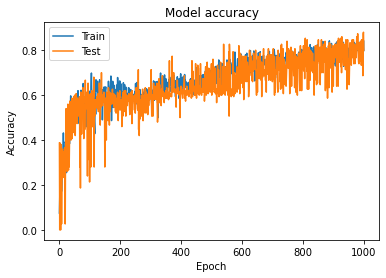

In [44]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

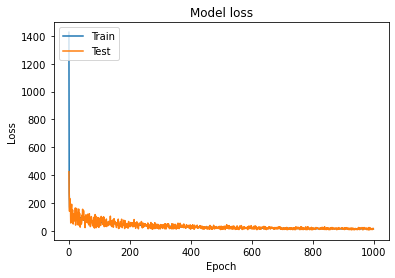

In [45]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

In [46]:
from sklearn.metrics import mean_squared_error, r2_score

y_i_predict =  model.predict(np.array(X))
for i in range(1, n):
    y_i_predict = model.predict(y_i_predict)
    rmse = (np.sqrt(mean_squared_error(df_n_rounds['y_' + str(i+1)].tolist(), y_i_predict)))
    r2 = r2_score(df_n_rounds['y_' + str(i+1)].tolist(), y_i_predict)

    print("The model performance for y_{} -> y_{}".format(i, i+1))
    print("--------------------------------------")
    print('RMSE is {}'.format(rmse))
    print('R2 score is {}'.format(r2))
    print("\n")

The model performance for y_1 -> y_2
--------------------------------------
RMSE is 33.99918246713917
R2 score is 0.8953547261784897


The model performance for y_2 -> y_3
--------------------------------------
RMSE is 49.75682943774657
R2 score is 0.8619662764073125


The model performance for y_3 -> y_4
--------------------------------------
RMSE is 65.65800259648091
R2 score is 0.8224062297236358


The model performance for y_4 -> y_5
--------------------------------------
RMSE is 81.61363833275703
R2 score is 0.7780433692722732


The model performance for y_5 -> y_6
--------------------------------------
RMSE is 97.60696396253228
R2 score is 0.7301832716720615


The model performance for y_6 -> y_7
--------------------------------------
RMSE is 113.63075222129868
R2 score is 0.6796749776372865


The model performance for y_7 -> y_8
--------------------------------------
RMSE is 129.6895376803062
R2 score is 0.6293744900487804


The model performance for y_8 -> y_9
-----------------